In [1]:
import sys
import os
import altair as alt
import pandas as pd
from toolz.curried import pipe

# # Create a new data transformer that stores the files in a directory
def json_dir(data, data_dir='altairdata'):
    os.makedirs(data_dir, exist_ok=True)
    return pipe(data, alt.to_json(filename=data_dir + '/{prefix}-{hash}.{extension}') )

# # Register and enable the new transformer
alt.data_transformers.register('json_dir', json_dir)
alt.data_transformers.enable('json_dir')

sys.path.append('..')
from scripts import wrangle_and_clean as wac

# Handle large data sets (default shows only 5000)
# See here: https://altair-viz.github.io/user_guide/data_transformers.html
alt.data_transformers.disable_max_rows()

alt.renderers.enable('jupyterlab')


RendererRegistry.enable('jupyterlab')

In [2]:
mxmh = wac.clean_data("../data/raw/mxmh_survey_results.csv")

In [3]:
# === COLOR PALETTE ===
okabe_ito_palette = [
    "#009E73",  # Green
    "#0072B2",  # Blue
    "#56B4E9",  # Sky Blue
    "#F0E442",  # Yellow
    "#E69F00",  # Orange
    "#D55E00",  # Vermillion
    "#CC79A7",  # Pink
    '#23338A',  # Dark Blue [colour blind safe addition]
]
# === FONT SETTING ===
font_choice = "Segoe UI"

legend_configuration = {"titleFontSize": 15,
    "labelFontSize": 13,
    "fillColor": '#F5F5F5',
    "padding": 10,
    "cornerRadius": 10,
    "labelFont": font_choice,
    "titleFont": font_choice
}

title_configuration = {
    "fontSize": 25,
    "anchor": "middle", 
    "font": font_choice
}

axis_configuration = {
    "labelFont": font_choice,
    "titleFont": font_choice,
    "labelFontSize": 15,
    "titleFontSize": 20
}

## Question 1:

In [4]:
mxmh = wac.clean_data("../data/raw/mxmh_survey_results.csv")

In [5]:
# === DATA PREP ===
genre_stats = mxmh.groupby('Fav genre', as_index=False).agg(
    avg_age=('Age', 'mean'),
    count=('Age', 'count')
)

max_y = mxmh.groupby("Age_Grouped")["Fav genre"].count().max()
max_y = min(max_y, 100)
x_range = [10, 70]
domain_list_ordered = ['Gospel', 'Rock', 'Classical', 'Folk', 'Jazz', 'Country', 
                       'Metal', 'R&B', 'Hip hop', 'Pop', 'EDM', 'Lofi', 'Rap', 
                       'Video game music', 'K pop', 'Latin']

# === COLOUR ===
color_range = okabe_ito_palette * len(genre_stats)
color_scale = alt.Scale(domain=domain_list_ordered, range=color_range)

# === INTERACTION ===
selection = alt.selection_point(
    fields=['Fav genre'],
    nearest=True,
    on='mouseover',
    clear='mouseout',  
    empty='none'
)

# === SCATTER ===
avg_age_chart = alt.Chart(genre_stats).mark_circle(
    size=200,
    stroke='black',
    strokeWidth=0.5
).encode(
    y=alt.Y('Fav genre:N', title="Genre", sort='-x'),
    x=alt.X('avg_age:Q', title="Average Age", scale=alt.Scale(domain=[10, 65])),
    color=alt.condition(selection, alt.Color('Fav genre:N', scale=color_scale, legend=None), alt.value('black')),
    tooltip=[
        alt.Tooltip('avg_age:Q', title='Average Age', format=".2f"),
        alt.Tooltip('count:Q', title='Number of Respondents')],
    size=alt.Size('count:Q', title="Count"),
).add_params(
    selection
)

# === SCATTER LABELS ===
genre_labels = alt.Chart(genre_stats).mark_text(
    align='left',
    baseline='middle',
    fontWeight='bold',
    fontSize=15,
    dx=15  
).encode(
    y=alt.Y('Fav genre:N', sort='-x', axis=alt.Axis(labels=False, ticks=True, domain=True)),
    x=alt.X('avg_age:Q'),
    text=alt.Text('Fav genre:N'),
    color=alt.condition(selection, alt.value('black'), alt.value('gray'))
)

# === AVERAGE AGE RULE LINE ===
overall_avg_age = mxmh['Age'].mean()
avg_age_line = alt.Chart(pd.DataFrame({'x': [overall_avg_age]})).mark_rule(
    color='red',
    strokeWidth=1, 
    opacity=0.2
).encode(
    x='x:Q'
).properties(
    width=500,
    height=400
)

# === COMBINED SCATTER ===
scatter_plot_with_line = alt.layer(
    avg_age_line,
    avg_age_chart,
    genre_labels
).properties(
    width=500,
    height=400
)

# === HISTOGRAM ===
age_hist = alt.Chart(mxmh).mark_bar(
    cornerRadiusEnd=3,
    stroke='black'
).encode(
    alt.X('Age_Grouped:Q', bin=alt.Bin(step=5), title="Grouped Ages", scale=alt.Scale(domain=x_range)),
    alt.Y('count()', title="Count", scale=alt.Scale(domain=[0, max_y])),
    color=alt.condition(selection, alt.Color('Fav genre:N', scale=color_scale), alt.value('lightgray'))
).transform_filter(
    selection
)

# === STATIC AXIS FOR HISTOGRAM ===
static_axis = alt.Chart(mxmh).transform_aggregate(
    count='count()', groupby=['Age_Grouped']
).transform_calculate(
    capped_count='min(datum.count, 70)' 
).mark_bar(
    opacity=0
).encode(
    x=alt.X('Age_Grouped:Q', title="Grouped Ages", scale=alt.Scale(domain=x_range), axis=alt.Axis(grid=False)),
    y=alt.Y('capped_count:Q', title="Count", scale=alt.Scale(domain=[0, max_y]))
).properties(
    width=300,
    height=300
)

# === HISTOGRAM + STATIC AXIS ===
histogram = alt.layer(static_axis, age_hist).properties(
    width=300,
    height=300 
)

# === TITLE ===
dynamic_title = alt.Chart(genre_stats).mark_text(
    align='center',
    baseline='middle',
    fontSize=20,
    fontWeight='bold',
    font=font_choice
).encode(
    text='Fav genre:N',
    opacity=alt.condition(selection, alt.value(1), alt.value(0)) 
).add_params(
    selection
).properties(
    width=300,
    height=60
)

# === TITLE AND HISTOGRAM ===
histogram_with_title = alt.vconcat(
    dynamic_title,
    histogram
)

In [6]:
# === SCATTER AND HISTOGRAM ===
chart_1 = alt.hconcat(
    scatter_plot_with_line,
    histogram_with_title
).resolve_scale(
    size='independent'
).properties(
    title="Average Age of Respondents for Each Genre"
).configure_axis(
    **axis_configuration
).configure_view(
    stroke=None
).configure_legend(
    **legend_configuration
).configure_title(
    **title_configuration
)

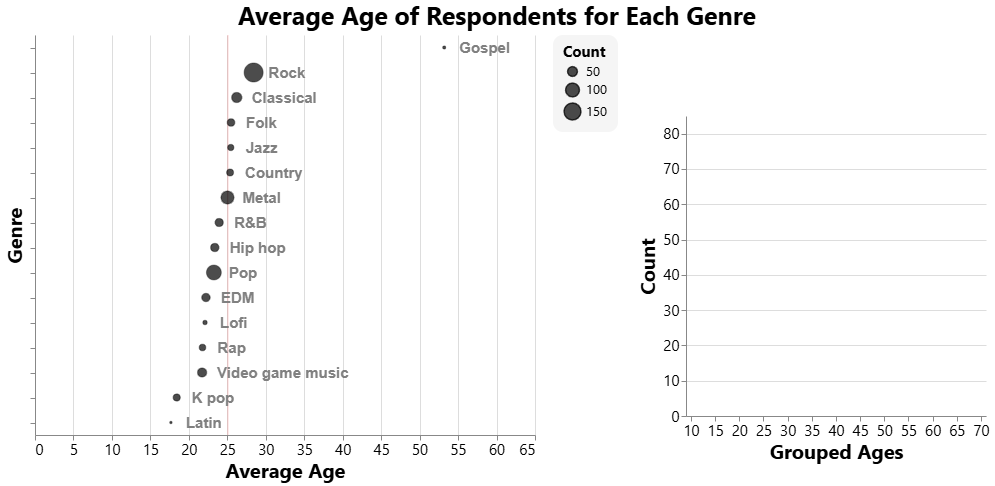

In [7]:
chart_1

## Question 2

In [8]:
mxmh = wac.clean_data("../data/raw/mxmh_survey_results.csv")

In [9]:
# === FONT SETTING ===
font_choice = "Segoe UI"

# === DATA PREP ===
mental_health_long = mxmh.melt(
    id_vars='Age',
    value_vars=['Anxiety_Level', 'Depression_Level', 'Insomnia_Level', 'OCD_Level'],
    var_name='Category',
    value_name='Level'
)

# === DROP DOWN ===
condition_param = alt.param(
    name='selected_condition',
    bind=alt.binding_select(
        options=['Anxiety_Level', 'Depression_Level', 'Insomnia_Level', 'OCD_Level'],
        labels=['Anxiety', 'Depression', 'Insomnia', 'OCD'], 
        name='Select Category: '
    ),
    value='Anxiety_Level'
)

# === COLOUR SCALE ===
color_scale = alt.Scale(
    domain=['Low', 'Medium', 'High'],
    range=['#56B4E9', '#0072B2', '#23338A']
)

# === VIOLIN PLOT ===
violin_2 = alt.Chart(mental_health_long).add_params(
    condition_param
).transform_filter(
    alt.datum.Category == condition_param
).transform_density(
    density='Age',
    groupby=['Level'],
    as_=['Age_value', 'density'],
    extent=[10, 80]
).mark_area(
    orient='horizontal',
    interpolate='monotone',
    stroke='black',
    strokeWidth=1
).encode(
    y=alt.Y('Age_value:Q', title='Age'),
    x=alt.X(
        'density:Q',
        stack='center',
        title=None,
        axis=alt.Axis(labels=False, values=[0], grid=False, ticks=True)
    ),
    color=alt.Color('Level:N', scale=color_scale),
    column=alt.Column(
        'Level:N',
        sort=['Low', 'Medium', 'High'],
        header=alt.Header(
            titleOrient='bottom',
            labelOrient='bottom',
            labelPadding=0,
            labelFontSize=15,
            titleFontSize=20
        )
    ),
    tooltip=[
        alt.Tooltip('Level:N', title='Level'),
        alt.Tooltip('Age_value:Q', title='Age', format=".1f"),
        alt.Tooltip('density:Q', title='Density', format=".3f")
    ]
).properties(
    width=300,
    height=300,
    title='Distribution of Age by Mental Health Level'
).configure_facet(
    spacing=0
).configure_view(
    stroke=None
).configure_legend(
    **legend_configuration
).configure_title(
    **title_configuration
).configure_axis(
    **axis_configuration
)

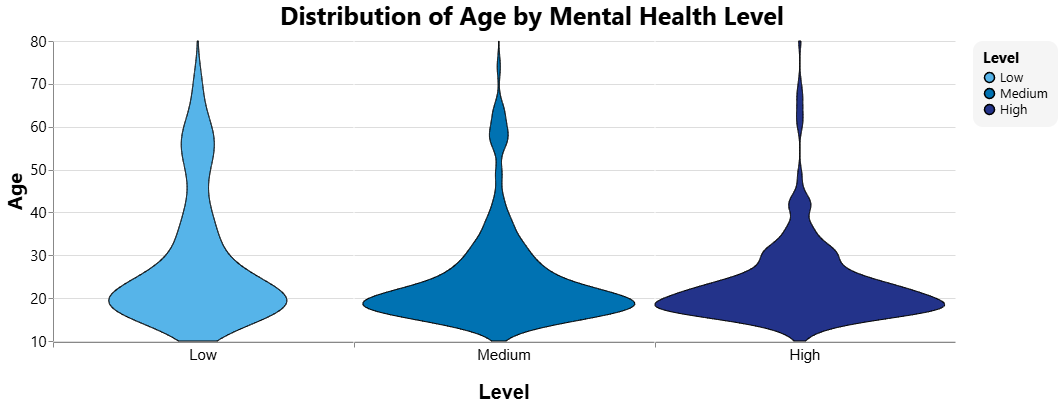

In [10]:
violin_2

## Question 3

In [11]:
mxmh = wac.clean_data("../data/raw/mxmh_survey_results.csv")

In [12]:
# === FONT SETTING ===
font_choice = "Segoe UI"

# === DATA PREP ===
bins = [10, 20, 30, 40, 50, 60, 100]
labels = ['10–20', '20–30', '30–40', '40–50', '50–60', '60+']
mxmh['Age_Group'] = pd.cut(mxmh['Age'], bins=bins, labels=labels, right=False)

genre_age_group = mxmh.groupby(['Fav genre', 'Age_Group'], observed=False).size().reset_index(name='count')

# === RADIO PARAM ===
age_param = alt.param(
    name='selected_age_group',
    bind=alt.binding_radio(
        options=labels,
        name='Select Age Group: '
    ),
    value='20–30'
)

# === BAR CHART ===
bar_3 = alt.Chart(genre_age_group).transform_filter(
    alt.datum.Age_Group == age_param
).mark_bar(
    cornerRadiusEnd=3,
    stroke='black'
).encode(
    x=alt.X('count:Q', title='Count'),
    y=alt.Y('Fav genre:N', title='Genre', sort='-x'),
    tooltip=[
        alt.Tooltip('Fav genre:N', title='Genre'),
        alt.Tooltip('count:Q', title='Count')
    ],
    color=alt.value('#D55E00') 
).add_params(
    age_param
).properties(
    title='Favourite Music Genre by Age Group',
    width=600,
    height=500
).configure_title(
    **title_configuration
).configure_axis(
    **axis_configuration
)

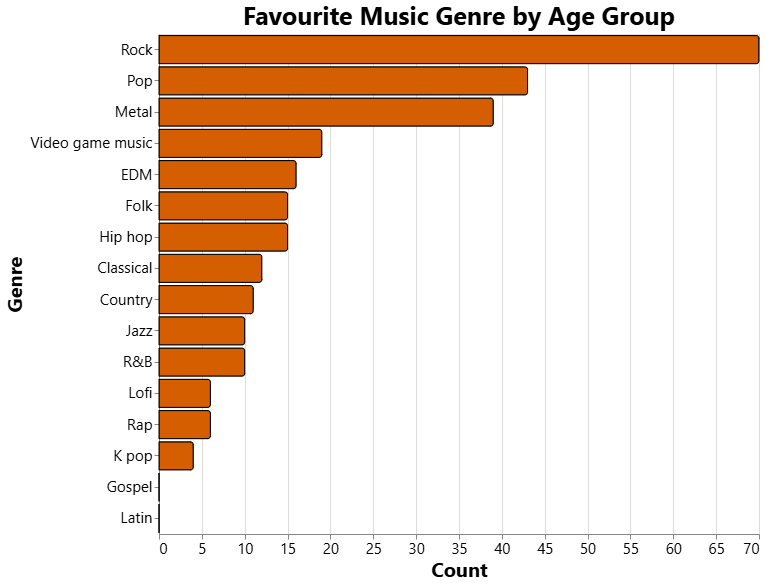

In [13]:
bar_3

## Question 4

In [14]:
mxmh = wac.clean_data("../data/raw/mxmh_survey_results.csv")

In [46]:
# === DATA PREP ===
def get_identity(row):
    if row['Instrumentalist'] == 'Yes' and row['Composer'] == 'Yes':
        return 'Both'
    elif row['Instrumentalist'] == 'Yes':
        return 'Instrumentalist'
    elif row['Composer'] == 'Yes':
        return 'Composer'
    else:
        return 'Neither'

mental_health_long = mxmh.melt(
    id_vars=['Age_Grouped', "Age", 'Instrumentalist', 'Composer'],
    value_vars=['Anxiety', 'Depression', 'Insomnia', 'OCD'],
    var_name='Category',
    value_name='Score'
)

mental_health_long['Musical_Hobbies'] = mental_health_long.apply(get_identity, axis=1)

# === COLOR SCALE ===
color_scale = alt.Scale(domain=['Both', 'Instrumentalist', 'Composer', 'Neither'], 
                        range=[okabe_ito_palette[3], okabe_ito_palette[0], okabe_ito_palette[4], okabe_ito_palette[2]])

# === INTERACTIONS + UI ===
interval = alt.selection_interval()

click = alt.selection_point(encodings=['color'])

condition_param = alt.param(
    name='selected_condition',
    bind=alt.binding_select(
        options=['Anxiety', 'Depression', 'Insomnia', 'OCD'],
        name='Select Category: '
    ),
    value='Anxiety'
)

# === SCATTER ===
scatter_4 = alt.Chart(mental_health_long).transform_filter(
    alt.datum.Category == condition_param
).mark_circle(
    size = 50,
    stroke='black',
    strokeWidth=0.3,
    opacity=0.5
).encode(
    alt.Y('Score:Q', title = "Self-Report Score", scale=alt.Scale(domain = [-0.5, 10.5])),
    alt.X('Age_Grouped:Q', title="Age"),
    color=
        alt.condition(interval, alt.Color('Musical_Hobbies:N', scale=color_scale), alt.value('lightgray'), title="Musical Hobbies"),
    tooltip=["Age", "Score", "Category"]
).add_params(
    interval,
    condition_param
).transform_filter(
    click
).properties(
    height=400,
    width=500
)

# === DATA PREP ===
bar_4 = alt.Chart(mental_health_long).transform_filter(
    alt.datum.Category == condition_param
).mark_bar(
    cornerRadiusEnd=3,
    stroke='black'
).encode(
    x=alt.X('count():Q', title="Count"),
    y=alt.Y(
        'Musical_Hobbies:N',
        sort=['Both', 'Instrumentalist', 'Composer', 'Neither'],
        scale=alt.Scale(domain=['Both', 'Instrumentalist', 'Composer', 'Neither']),
        title=None),
    color=alt.condition(click, 'Musical_Hobbies', alt.value('lightgray'), title="Musical Hobbies")
).transform_filter(
    interval
).add_params(
    click,
    condition_param
).properties(
    height=100,
    width=500
)

# === FINAL CHART ===
chart_4 = (scatter_4 & bar_4).properties(
    title='Musical Hobbies By Age for Different Mental Health Scores',
).configure_legend(
    **legend_configuration
).configure_title(
    **title_configuration
).configure_axis(
    **axis_configuration
)

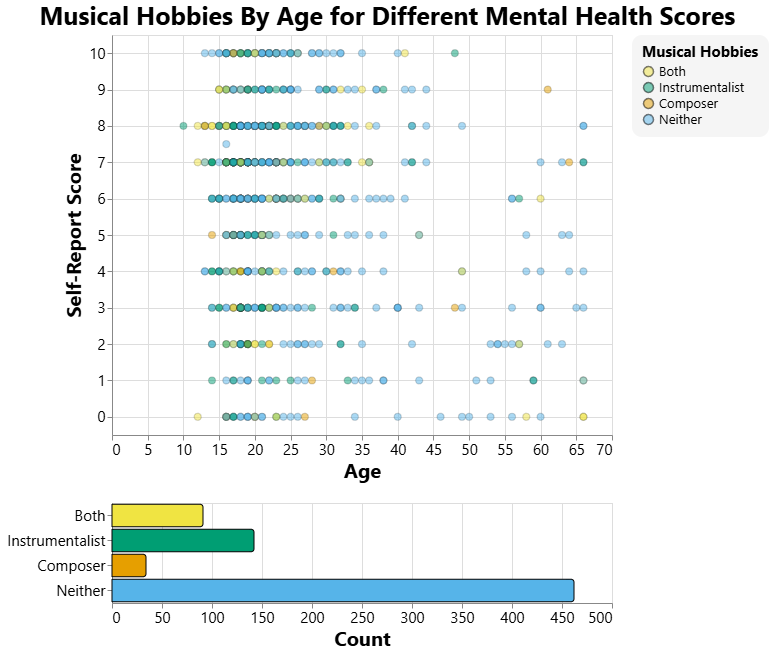

In [47]:
chart_4